###### working directory: G:\My Drive\Data\Precinct Data CA 2016\Notebooks

In [1]:
from pathlib import Path
import json
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import shapely
import shapely.geometry as sg
import folium
import geojson
import fiona

import matplotlib.cm as cm, matplotlib.font_manager as fm
from datetime import datetime as dt
from shapely.geometry import Polygon
from geopy.distance import great_circle
from geopandas import GeoDataFrame
import descartes

%matplotlib inline

### This notebook does the following:
    1. Reads in precinct data with geo
    2. Reads in census data with geo
    3. Joins precinct geodata with census data geodata
    4. Creates a geofile with census boundaries with precinct data
    5. Creates the new geofile as a pandas dataframe. 

### Step 1. Read in GeoData

Reading in PRECINCT geo data for CA Congressional 50th District Precinct info

In [2]:
gdf_voter = gpd.read_file(r'G:\My Drive\Data\Precinct Data CA 2016\Geo_Files\voter_data_2016_export.geojson', driver='GeoJSON')
gdf_voter.head(2)

,precinct,x_precinct,y_precinct,party,votes,geometry
0,419500,-117.252028,33.387489,democratic,384,POINT (-117.25203 33.38749)
1,419500,-117.252028,33.387489,republican,307,POINT (-117.25203 33.38749)


In [3]:
# number of rows and columns in df
total_rows=len(gdf_voter.axes[0])
total_cols=len(gdf_voter.axes[1])
print("Number of Rows: "+str(total_rows))
print("Number of Columns: "+str(total_cols))

Number of Rows: 1066
Number of Columns: 6


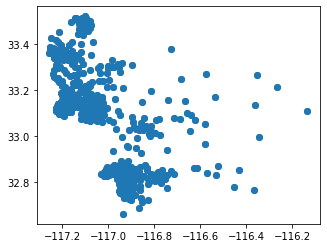

In [4]:
gdf_voter.plot()

### Step 2.  Reading geo data for CA Congressional 50th District

In [5]:
# reading GEOJSON File
gdf_50th = gpd.read_file(r'G:\My Drive\Data\Race Eth ACS 2017\Geo_Files\CA_congress.geojson', driver='GeoJSON')
gdf_50th.head(2)

,GEOID,geometry
0,6065051200,"MULTIPOLYGON (((-117.14876 33.47290, -117.1493..."
1,6065049600,"POLYGON ((-117.16311 33.52238, -117.16311 33.5..."


In [6]:
# number of rows and columns in df
total_rows=len(gdf_50th.axes[0])
total_cols=len(gdf_50th.axes[1])
print("Number of Rows: "+str(total_rows))
print("Number of Columns: "+str(total_cols))

Number of Rows: 159
Number of Columns: 2


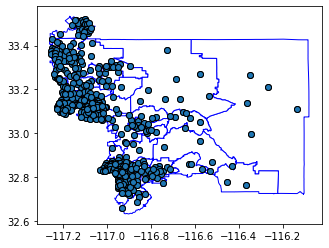

In [7]:
gdf_ct = gdf_50th.plot(color='white', edgecolor='blue', zorder=1)
gdf_voter.plot(ax=gdf_ct,  edgecolor='black', zorder=2);


### Step 3.  Joining Census tract boudaries and precinct data

In [8]:
type(gdf_50th)

geopandas.geodataframe.GeoDataFrame

In [9]:
type(gdf_voter)

geopandas.geodataframe.GeoDataFrame

In [10]:
data = gpd.sjoin(gdf_50th, gdf_voter, how='left', op='intersects')

In [11]:
# sort by columns
data.sort_values(by=['votes'])

,GEOID,geometry,index_right,precinct,x_precinct,y_precinct,party,votes
72,6073020710,"MULTIPOLYGON (((-117.04709 33.06868, -117.0473...",789.0,999071.0,-117.026354,33.064522,republican,0.0
24,6073019207,"POLYGON ((-117.18396 33.25269, -117.18393 33.2...",818.0,999184.0,-117.235875,33.258208,democratic,0.0
153,6073020018,"POLYGON ((-117.19511 33.15313, -117.19518 33.1...",934.0,999262.0,-117.218347,33.140060,democratic,0.0
6,6073021000,"POLYGON ((-116.22336 32.72628, -116.22333 32.7...",797.0,999079.0,-116.361437,33.136743,republican,0.0
106,6073016804,"POLYGON ((-116.89356 32.87086, -116.89357 32.8...",706.0,999025.0,-116.912861,32.868387,democratic,0.0
...,...,...,...,...,...,...,...,...
111,6073013410,"POLYGON ((-116.96262 32.70027, -116.96281 32.7...",NaN,NaN,NaN,NaN,NaN,NaN
121,6073020214,"POLYGON ((-117.07642 33.12571, -117.07645 33.1...",NaN,NaN,NaN,NaN,NaN,NaN
135,6073016301,"POLYGON ((-116.95098 32.80430, -116.95132 32.8...",NaN,NaN,NaN,NaN,NaN,NaN
143,6065043218,"MULTIPOLYGON (((-117.12179 33.51653, -117.1219...",NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
type(data)

geopandas.geodataframe.GeoDataFrame

In [13]:
data.head(2)

,GEOID,geometry,index_right,precinct,x_precinct,y_precinct,party,votes
0,6065051200,"MULTIPOLYGON (((-117.14876 33.47290, -117.1493...",1014.0,33001.0,-117.160309,33.495322,democratic,224.0
0,6065051200,"MULTIPOLYGON (((-117.14876 33.47290, -117.1493...",1015.0,33001.0,-117.160309,33.495322,republican,242.0


In [14]:
# number of rows and columns in df
total_rows=len(data.axes[0])
total_cols=len(data.axes[1])
print("Number of Rows: "+str(total_rows))
print("Number of Columns: "+str(total_cols))

Number of Rows: 1072
Number of Columns: 8


### Step 4.  Data manipulation:

a.) aggregating race data and summarizing on votes


b.) pivoting aggregate dataframe to derive total votes and percentage of votes won by dems. 

In [15]:
# convert geopandas dataframe to pandas dataframe
df = pd.DataFrame(data)
type(df)

pandas.core.frame.DataFrame

In [16]:
# display all columns
pd.set_option('display.max_columns', None)

# # reset index and drop the old one
# df.reset_index(drop=True, inplace=True)

# sorting
df.sort_values(by=['votes'], inplace=True)

df.head(2)

,GEOID,geometry,index_right,precinct,x_precinct,y_precinct,party,votes
72,6073020710,"MULTIPOLYGON (((-117.04709 33.06868, -117.0473...",789.0,999071.0,-117.026354,33.064522,republican,0.0
24,6073019207,"POLYGON ((-117.18396 33.25269, -117.18393 33.2...",818.0,999184.0,-117.235875,33.258208,democratic,0.0


In [17]:
total_votes = df['votes'].sum()
total_votes

282901.0

In [18]:
df.columns


Index(['GEOID', 'geometry', 'index_right', 'precinct', 'x_precinct',
       'y_precinct', 'party', 'votes'],
      dtype='object')

In [19]:
selection_a = ['GEOID', 'precinct', 'party',
               'votes', 'x_precinct', 'y_precinct','geometry',]

df = pd.DataFrame(df[selection_a])
df

,GEOID,precinct,party,votes,x_precinct,y_precinct,geometry
72,6073020710,999071.0,republican,0.0,-117.026354,33.064522,"MULTIPOLYGON (((-117.04709 33.06868, -117.0473..."
24,6073019207,999184.0,democratic,0.0,-117.235875,33.258208,"POLYGON ((-117.18396 33.25269, -117.18393 33.2..."
153,6073020018,999262.0,democratic,0.0,-117.218347,33.140060,"POLYGON ((-117.19511 33.15313, -117.19518 33.1..."
6,6073021000,999079.0,republican,0.0,-116.361437,33.136743,"POLYGON ((-116.22336 32.72628, -116.22333 32.7..."
106,6073016804,999025.0,democratic,0.0,-116.912861,32.868387,"POLYGON ((-116.89356 32.87086, -116.89357 32.8..."
...,...,...,...,...,...,...,...
111,6073013410,NaN,NaN,NaN,NaN,NaN,"POLYGON ((-116.96262 32.70027, -116.96281 32.7..."
121,6073020214,NaN,NaN,NaN,NaN,NaN,"POLYGON ((-117.07642 33.12571, -117.07645 33.1..."
135,6073016301,NaN,NaN,NaN,NaN,NaN,"POLYGON ((-116.95098 32.80430, -116.95132 32.8..."
143,6065043218,NaN,NaN,NaN,NaN,NaN,"MULTIPOLYGON (((-117.12179 33.51653, -117.1219..."


In [20]:
# number of rows and columns in df
total_rows=len(df.axes[0])
total_cols=len(df.axes[1])
print("Number of Rows: "+str(total_rows))
print("Number of Columns: "+str(total_cols))

Number of Rows: 1072
Number of Columns: 7


In [21]:
df.columns

Index(['GEOID', 'precinct', 'party', 'votes', 'x_precinct', 'y_precinct',
       'geometry'],
      dtype='object')

#### Aggregating data

In [22]:
# columns to group by:
groupby_these_cols = ['GEOID', 'party']

# aggregating by all race data and summarizing on votes
agg = df.groupby(groupby_these_cols).agg(
                                    votes=('votes', sum)).reset_index()
agg.head(2)

,GEOID,party,votes
0,6065043216,democratic,825.0
1,6065043216,republican,1276.0


In [23]:
# number of rows and columns in df
total_rows=len(agg.axes[0])
total_cols=len(agg.axes[1])
print("Number of Rows: "+str(total_rows))
print("Number of Columns: "+str(total_cols))

Number of Rows: 286
Number of Columns: 3


In [24]:
# sorting
agg.sort_values(by=['party'], inplace=True)
agg.head(4)

,GEOID,party,votes
0,6065043216,democratic,825.0
148,6073019106,democratic,1490.0
150,6073019107,democratic,188.0
152,6073019207,democratic,218.0


In [25]:
# pivoting the aggregate to get total votes and percentage of votes won by Dems
pivot2 = agg.pivot(index='GEOID', columns='party', values='votes')
pivot2.reset_index()
pivot2.head(3)

party,democratic,republican
GEOID,,
6065043216,825.0,1276.0
6065043220,500.0,623.0
6065043222,632.0,1438.0


In [26]:
# doing basic math
pivot2['total_votes_by_ct'] = pivot2['democratic'] + pivot2['republican']
pivot2['dem_pct_vote'] = pivot2['democratic'] / pivot2['total_votes_by_ct'] * 100
pivot2 = pivot2.round({'dem_pct_vote': 1})
pivot2

party,democratic,republican,total_votes_by_ct,dem_pct_vote
GEOID,,,,
6065043216,825.0,1276.0,2101.0,39.3
6065043220,500.0,623.0,1123.0,44.5
6065043222,632.0,1438.0,2070.0,30.5
6065043246,546.0,1230.0,1776.0,30.7
6065043248,584.0,1103.0,1687.0,34.6
...,...,...,...,...
6073021205,871.0,2393.0,3264.0,26.7
6073021206,485.0,1495.0,1980.0,24.5
6073021302,3.0,6.0,9.0,33.3


In [27]:
# flatten the pivot table for tidy data
pivot2 = pivot2.rename_axis(None, axis=1,)
pivot3 = pivot2.rename_axis(None, axis=1).reset_index()

In [30]:
pivot3.head(2)

,GEOID,democratic,republican,total_votes_by_ct,dem_pct_vote
0,6065043216,825.0,1276.0,2101.0,39.3
1,6065043220,500.0,623.0,1123.0,44.5


In [31]:
total_votes = pivot3['total_votes_by_ct'].sum()
total_votes

282901.0

### Step 5. Join Manipulated data back to geospatial data for census data geo 

In [33]:
gdf_50th.head(2)

,GEOID,geometry
0,6065051200,"MULTIPOLYGON (((-117.14876 33.47290, -117.1493..."
1,6065049600,"POLYGON ((-117.16311 33.52238, -117.16311 33.5..."


In [34]:
# reading GEOJSON File
gdf_50th = gpd.read_file(r'G:\My Drive\Data\Race Eth ACS 2017\Geo_Files\CA_congress.geojson', driver='GeoJSON')


# Joining Census Tract label and County label
gdf_final = pd.merge(gdf_50th, pivot3, on='GEOID', how='inner')
gdf_final.head(2)


,GEOID,geometry,democratic,republican,total_votes_by_ct,dem_pct_vote
0,6065051200,"MULTIPOLYGON (((-117.14876 33.47290, -117.1493...",224.0,242.0,466.0,48.1
1,6073020029,"POLYGON ((-117.18903 33.14812, -117.18895 33.1...",279.0,223.0,502.0,55.6


In [35]:

# number of rows and columns in df
total_rows=len(gdf_final.axes[0])
total_cols=len(gdf_final.axes[1])
print("Number of Rows: "+str(total_rows))
print("Number of Columns: "+str(total_cols))

Number of Rows: 143
Number of Columns: 6


In [37]:
total_votes = gdf_final['total_votes_by_ct'].sum()
total_votes

282901.0

In [38]:
# creating json file
gdf_final.to_file(r'G:\My Drive\Data\Precinct Data CA 2016\Geo_Files\precinct_data_2016_by_ct_export_submitted.json', driver='GeoJSON')

# creating json file
gdf_final.to_file(r'G:\My Drive\Data\Precinct Data CA 2016\Geo_Files\precinct_data_2016_by_ct_export_submitted.geojson', driver='GeoJSON')

# creating csv file
gdf_final.to_csv(r'G:\My Drive\Data\Precinct Data CA 2016\Geo_Files\precinct_data_2016_by_ct_export_submitted.csv', index=False)